In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import os
from faces_clustering import get_files_folder, VideoClustering, is_image

Using TensorFlow backend.


In [2]:
video_path = "C:/Users/paulo/Documents/videos360/vlog_gelo.mp4"

In [3]:
dir_path = video_path.split('.')[0]
dir_path

'C:/Users/paulo/Documents/videos360/vlog_gelo'

## Extracting Frames

In [ ]:
cap=cv2.VideoCapture(video_path)
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [ ]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Extracting Viewports

In [4]:
from faces_clustering import Equirec2Perspec as E2P
from mtcnn import MTCNN

In [5]:
import cv2
import numpy as np

In [6]:
def detect_faces(pixels_rgb):
    
    detector = MTCNN()
    results = detector.detect_faces(pixels_rgb)
    
    faces = []
    bounds = []
    for result in results:
        if result['confidence'] >= 0.7:
            x1, y1, width, height = result['box']
            x2, y2 = x1 + width, y1 + height
            x1 = max(x1,0)
            y1 = max(y1,0)
            face = pixels_rgb[y1:y2, x1:x2]

            if face.shape[0] > 0 and face.shape[1] > 0:
                faces.append(face)
                bounds.append((x1,x2,y1,y2))

                pixels_rgb = cv2.rectangle(pixels_rgb, (x1,y1), (x2,y2), (255,0,0), 5)
    return pixels_rgb, bounds

In [7]:
frames = get_files_folder(dir_path, is_image)
frames

['C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1008.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1032.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1056.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1080.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1104.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1128.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1152.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1176.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_120.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1200.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1224.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1248.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1272.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1296.jpg',
 'C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_1320.jpg',
 'C:/Users/paulo/Documents

In [8]:
equ = E2P.Equirectangular('C:/Users/paulo/Documents/videos360/vlog_gelo\\frame_7488.jpg')

#equ = E2P.Equirectangular("C:/Users/paulo/Pictures/equ_earth.png")

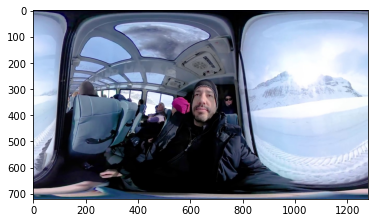

In [9]:
plt.imshow(equ._img[:,:,::-1])

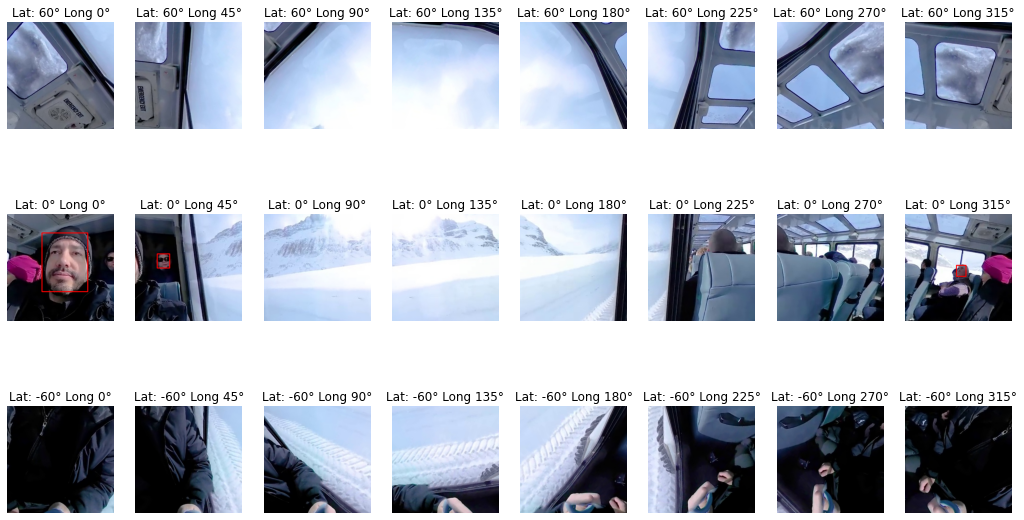

In [16]:
all_bounds = []
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(18, 10))

for i in range(3):
    for j in range(8):
        lat = i*(-60)+60
        long = 45*j
        img = equ.GetPerspective(60, 60, long, lat, 720)    
        img, bounds = detect_faces(np.uint16(img[:,:,::-1]))       
        all_bounds = all_bounds+bounds

        axes[i,j].set_title(f'Lat: {lat}° Long {long}°')
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
plt.show()

In [11]:
all_bounds

[(235, 543, 127, 522), (512, 580, 339, 423)]

In [12]:
img, bounds = detect_faces(np.uint16(equ._img[:,:,::-1]))  

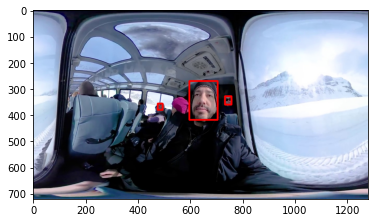

In [13]:
plt.imshow(img)

In [14]:
bounds

[(597, 705, 270, 418), (733, 758, 328, 360), (476, 495, 356, 380)]